# Rapid Airfoil Analysis with NeuralFoil

This is a brief demo of how [NeuralFoil](https://github.com/peterdsharpe/NeuralFoil) can be used to rapidly analyze airfoils in AeroSandbox.

## Airfoil Definition

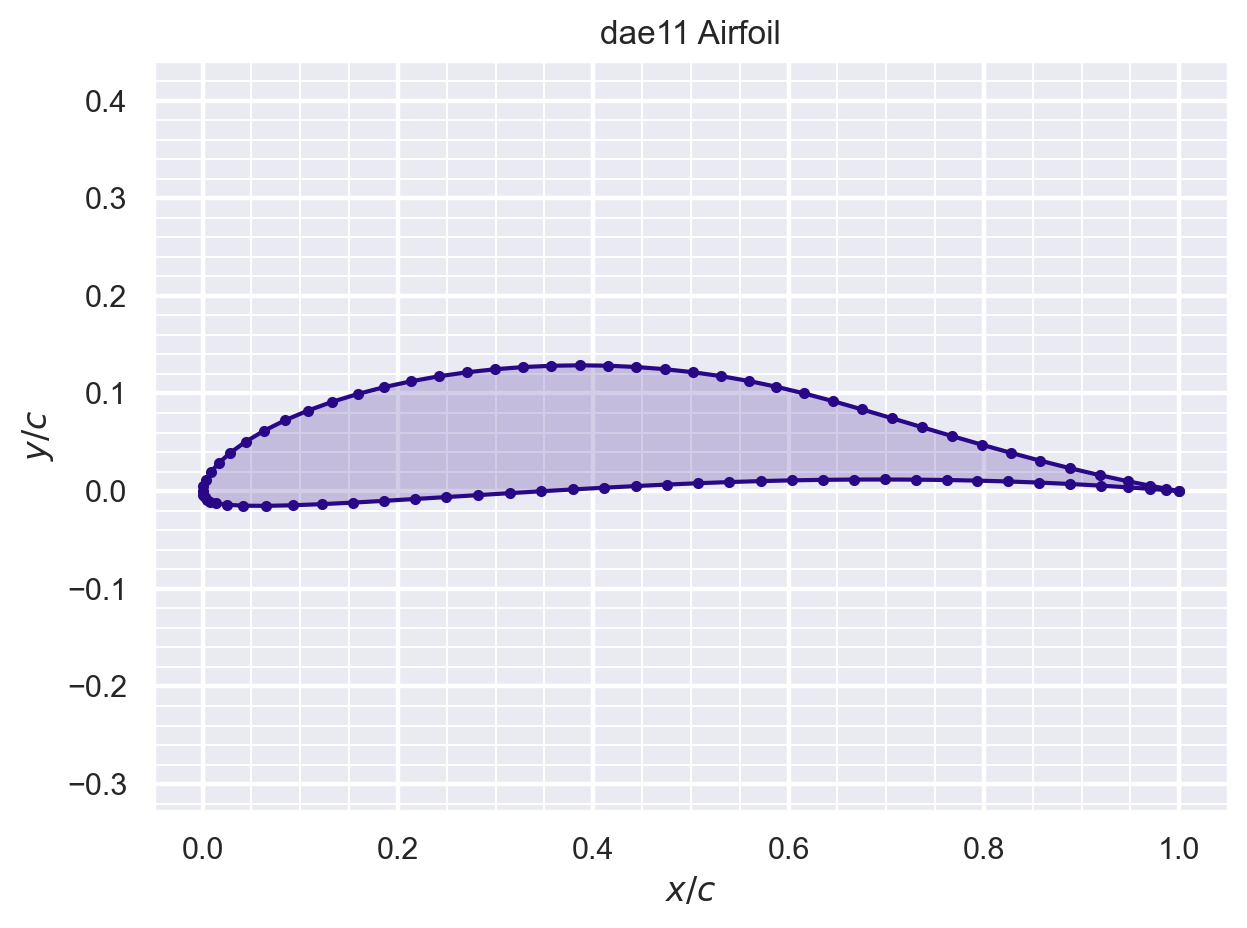

In [1]:
import aerosandbox as asb
import aerosandbox.numpy as np

af = asb.Airfoil("dae11")
af.draw()

## Airfoil Analysis

Basic usage:

In [2]:
af.get_aero_from_neuralfoil(
    alpha=5,
    Re=1e6,
    mach=0.2,
)

{'CL': array([1.26894976]),
 'CD': array([0.00729044]),
 'CM': array([-0.13829505]),
 'Cpmin': array([-1.56964438]),
 'Top_Xtr': array([0.55109842]),
 'Bot_Xtr': array([1.01252186]),
 'mach_crit': array([0.50653411]),
 'mach_dd': array([0.61425584]),
 'Cpmin_0': array([-1.54642471])}

Advanced usage, with control surfaces and varying model sizes:

In [3]:
af.get_aero_from_neuralfoil(
    alpha=5,
    Re=1e6,
    mach=0.2,
    model_size="xxxlarge",  # Can be "xsmall", "small", "medium", "large", "xlarge", "xxlarge", or "xxxlarge"
    control_surfaces=[
        asb.ControlSurface(
            name="aileron",
            deflection=10,  # Positive is trailing-edge down
            hinge_point=0.75,
        )
    ],
)

{'CL': array([1.70314795]),
 'CD': array([0.02650781]),
 'CM': array([-0.11826445]),
 'Cpmin': array([-3.3187115]),
 'Top_Xtr': array([0.22596062]),
 'Bot_Xtr': array([0.9938086]),
 'mach_crit': array([0.38211223]),
 'mach_dd': array([0.48983396]),
 'Cpmin_0': array([-3.26961798])}

Vectorized usage:

In [4]:
af.get_aero_from_neuralfoil(
    alpha=np.array([0, 5, 10, 15]),
    Re=1e6,
    mach=0.2,
)

{'CL': array([0.66388107, 1.26894976, 1.65109586, 1.6084796 ]),
 'CD': array([0.0079375 , 0.00729044, 0.01551829, 0.06835372]),
 'CM': array([-0.13104111, -0.13829505, -0.12226711, -0.09198865]),
 'Cpmin': array([-1.08847296, -1.56964438, -2.91615812, -5.41153887]),
 'Top_Xtr': array([0.61863378, 0.55109842, 0.30184846, 0.04486824]),
 'Bot_Xtr': array([0.25222506, 1.01252186, 1.00627734, 0.9940243 ]),
 'mach_crit': array([0.57029148, 0.50653411, 0.40253656, 0.31047366]),
 'mach_dd': array([0.67801322, 0.61425584, 0.5102583 , 0.41819539]),
 'Cpmin_0': array([-1.07237124, -1.54642471, -2.87301954, -5.33148626])}

Note that vectorization must be with 1D arrays. You can flatten higher-dimensional arrays to achieve this.

For example, this shows vectorized analysis across a 2D grid in angle of attack and Reynolds number:

In [5]:
af = asb.Airfoil("naca4412")

alpha = np.linspace(-15, 15, 181)
re = np.geomspace(1e3, 1e8, 6)

Alpha, Re = np.meshgrid(alpha, re)

aero_flattened = af.get_aero_from_neuralfoil(
    alpha=Alpha.flatten(),
    Re=Re.flatten(),
    mach=0,
    model_size="xxxlarge",
)
Aero = {
    key: value.reshape(Alpha.shape)
    for key, value in aero_flattened.items()
}

We can plot the results:

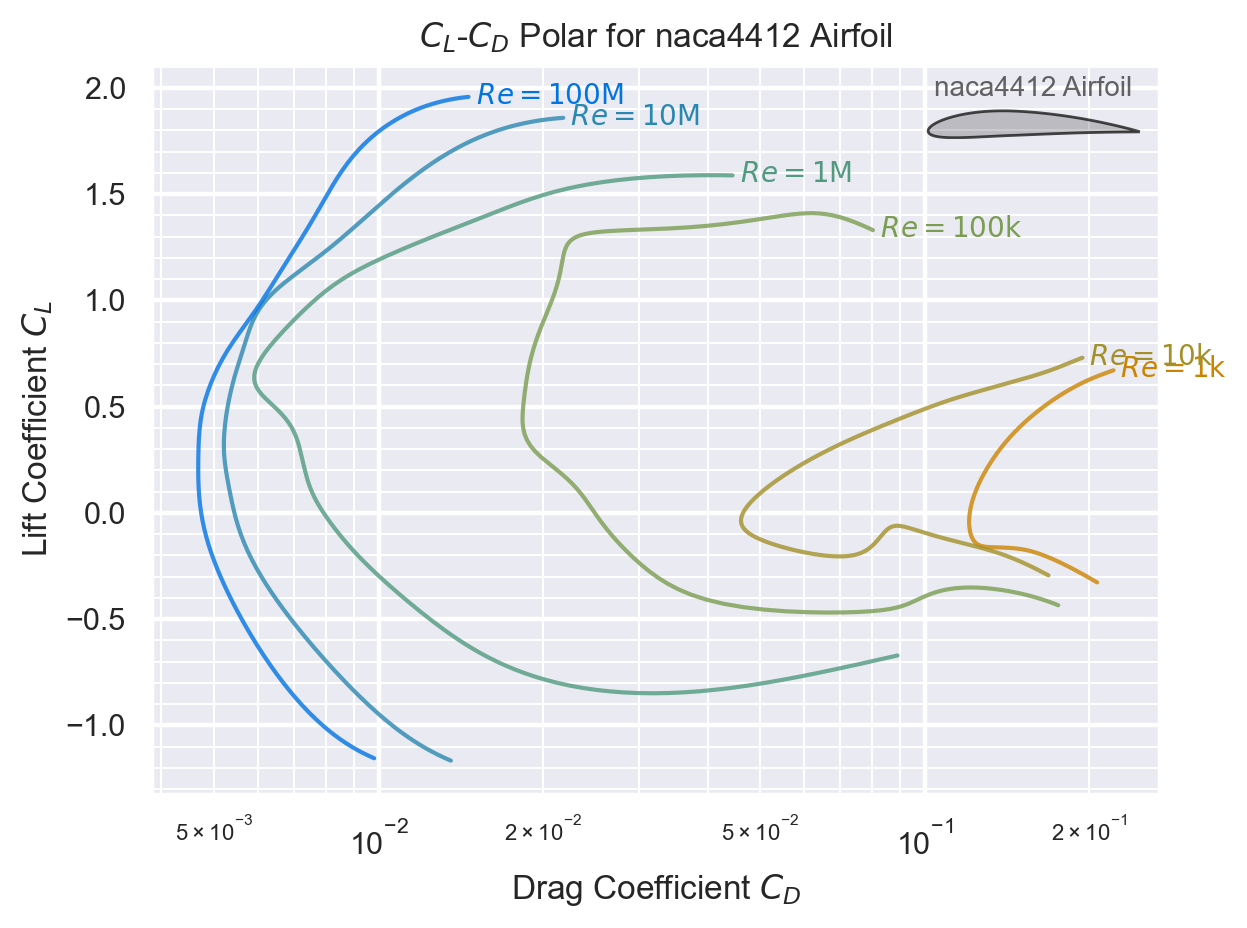

In [6]:
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p
from matplotlib.colors import LinearSegmentedColormap
from aerosandbox.tools.string_formatting import eng_string

fig, ax = plt.subplots()
colors = LinearSegmentedColormap.from_list(
    "custom_cmap",
    colors=[
        p.adjust_lightness(c, 0.8) for c in
        ["orange", "darkseagreen", "dodgerblue"]
    ]
)(np.linspace(0, 1, len(re)))

for i in range(len(re)):
    line, = ax.plot(
        Aero["CD"][i, :],
        Aero["CL"][i, :],
        color=colors[i], alpha=0.8,
    )

    plt.annotate(
        f" $Re = \\mathrm{{{eng_string(re[i])}}}$",
        xy=(line.get_xdata()[-1], line.get_ydata()[-1]),
        color=colors[i],
        ha="left", va="center", fontsize=10
    )

afax = ax.inset_axes([0.76, 0.802, 0.23, 0.23])
afax.fill(
    af.x(), af.y(),
    facecolor=(0, 0, 0, 0.2), linewidth=1, edgecolor=(0, 0, 0, 0.7)
)
afax.annotate(
    text=f"{af.name} Airfoil\n",
    xy=(0.5, 0),
    ha="center", va="bottom", fontsize=10,
    alpha=0.7
)
afax.axis('off')
afax.axis('equal')

plt.xscale('log')
p.show_plot(
    title=f"$C_L$-$C_D$ Polar for {af.name} Airfoil",
    xlabel="Drag Coefficient $C_D$",
    ylabel="Lift Coefficient $C_L$",
)

## Post-Stall Airfoil Analysis

Neuralfoil returns reasonably-accurate results for a 360 degree angle of attack range:

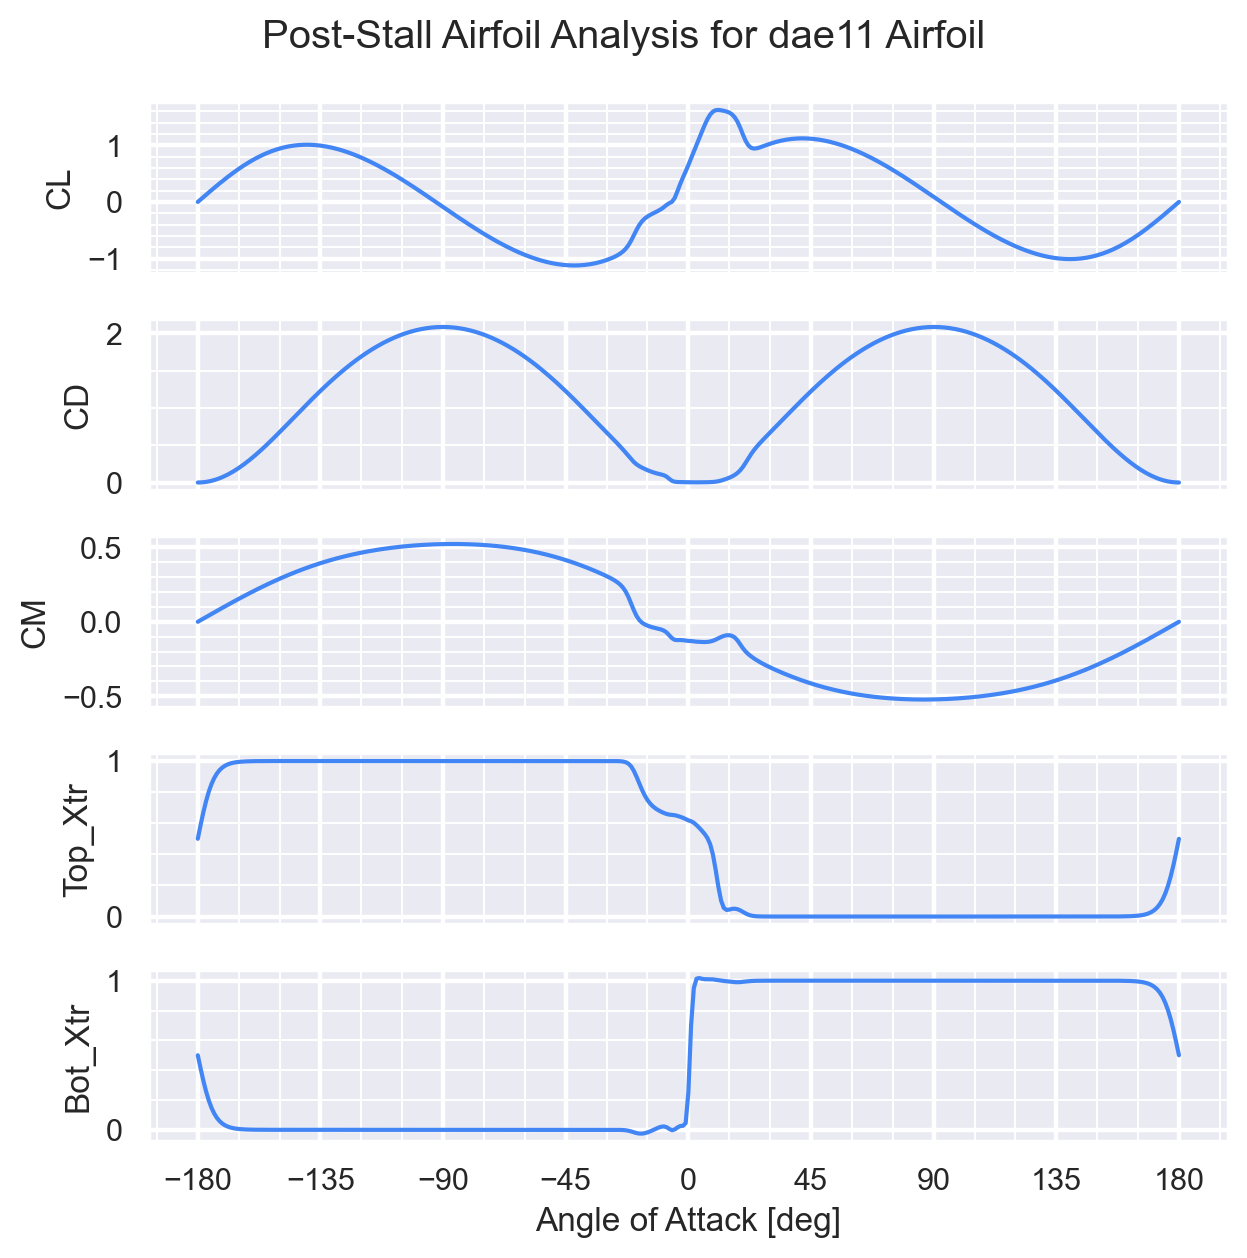

In [7]:
af = asb.Airfoil("dae11")

alpha = np.linspace(-180, 180, 361)
aero = af.get_aero_from_neuralfoil(
    alpha=alpha,
    Re=1e6,
    mach=0,
)

keys_to_plot = ["CL", "CD", "CM", "Top_Xtr", "Bot_Xtr"]

fig, ax = plt.subplots(len(keys_to_plot), 1, figsize=(6.4, 6.4), sharex=True)
for i, key in enumerate(keys_to_plot):
    plt.sca(ax[i])
    plt.plot(
        alpha,
        aero[key],
    )
    plt.ylabel(key)
    p.set_ticks(45, 15)
    from matplotlib.ticker import AutoMinorLocator

    ax[i].yaxis.set_minor_locator(AutoMinorLocator())

p.show_plot(
    title=f"Post-Stall Airfoil Analysis for {af.name} Airfoil",
    xlabel="Angle of Attack [deg]",
    set_ticks=False
)

## Transonic Airfoil Analysis

Compressible aerodynamics are computed using a Laitone-rule (higher-order version of Prandtl-Glauert or Karman-Tsien) correction. The basic chain of computation here is:
1. NeuralFoil predicts `Cpmin_0` (see key in the dictionary), which is the minimum pressure coefficient on the airfoil at incompressible conditions. This is a function of the airfoil shape, angle of attack, and Reynolds number.
2. We figure out at which Mach number these two quantities equal:
  - The Laitone-rule-corrected compressible `Cpmin`, based on `Cpmin_0`.
  - The sonic pressure coefficient, which is a function of the Mach number.
  It turns out that solving for the Mach number that causes these two value to be equal does not admit closed-form solution. Instead, we use a pre-computed symbolic-regression-derived solution to this implicit relation. (This "fit" introduces near-zero error.) This Mach number is then considered the critical Mach number
3. In parallel with the previous step, $C_L$, $C_D$, and $C_M$ coefficients are corrected using a Laitone-rule correction up to the specified Mach number. An empirically-tuned modification of the $\beta = \sqrt{1 - M^2}$ resolves the singularity at $M = 1$, and parameters of this modification were pre-computed to best match known calibration data.
4. If the specified Mach number exceeds the critical Mach number, wave drag and a buffet model are applied.


This NeuralFoil-based procedure does a surprisingly accurate (+- 0.01 Mach, typically) job of predicting $M_{crit}$, and this $M_{crit}$ value is directly accessible for any airfoil:

In [8]:
af = asb.Airfoil("rae2822")

af.get_aero_from_neuralfoil(
    alpha=2.31,
    Re=6.5e6,
    mach=0.729
)

{'CL': array([0.43544203]),
 'CD': array([0.01366227]),
 'CM': array([-0.13056242]),
 'Cpmin': array([-1.40945629]),
 'Top_Xtr': array([0.1012425]),
 'Bot_Xtr': array([0.55788641]),
 'mach_crit': array([0.57633916]),
 'mach_dd': array([0.6840609]),
 'Cpmin_0': array([-1.03568411])}

We can also plot the compressible aerodynamics, :

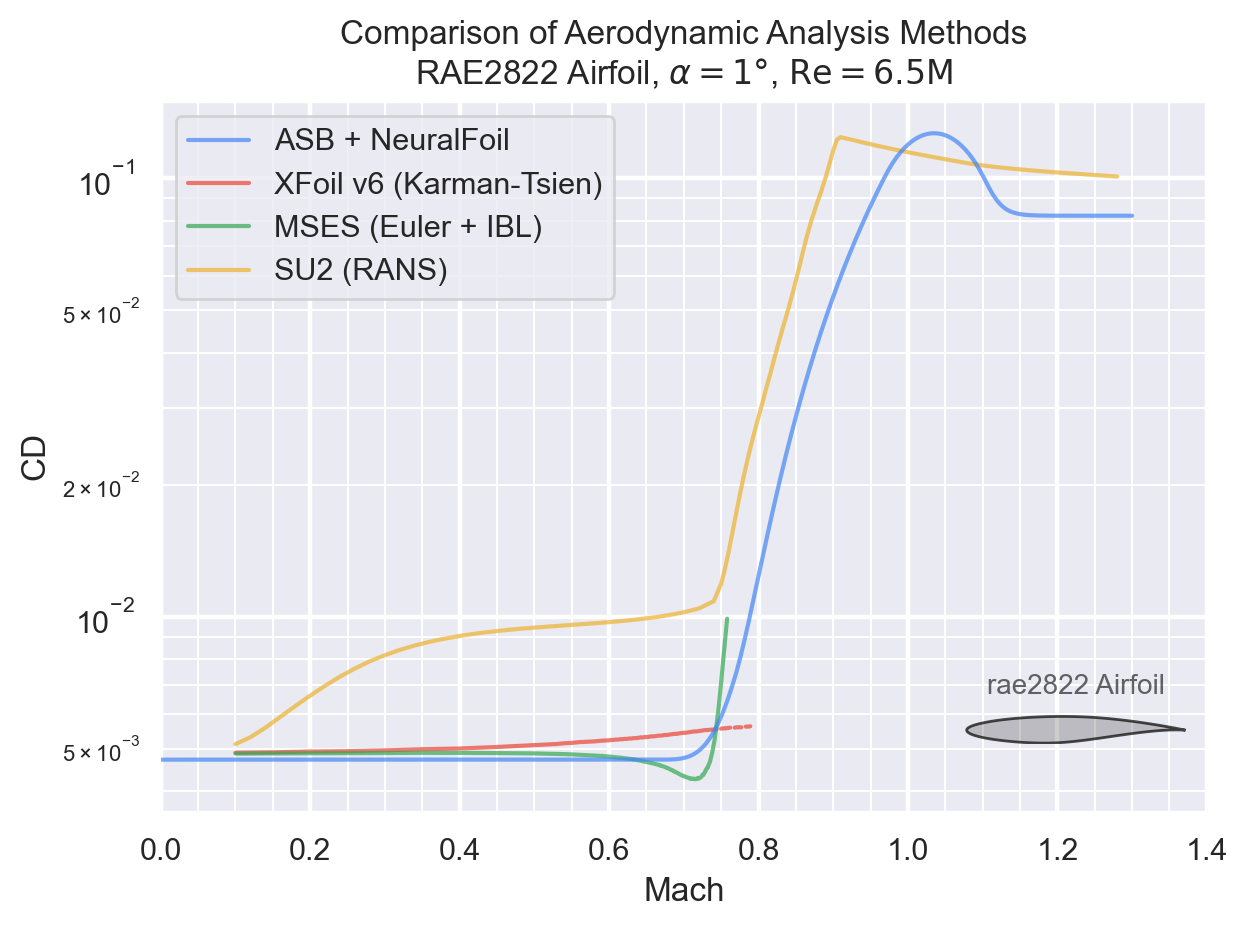

In [9]:
import json
from pathlib import Path

data_folder = Path(".") / "assets" / "RAE2822_alpha_1deg_Re_6500000"


def get_data(filename):
    with open(filename) as f:
        data = f.readlines()

    data = [
        json.loads(line)
        for line in data
    ]

    data = {
        k: np.array([d[k] for d in data])
        for k in data[0].keys()
    }

    order = np.argsort(data['mach'])

    data = {
        k: v[order]
        for k, v in data.items()
    }

    return data


machs = np.linspace(0, 1.3, 500)
airfoil = asb.Airfoil("rae2822")
asb_aero = airfoil.get_aero_from_neuralfoil(1, 6.5e6, machs)
asb_aero["mach"] = machs

datas = {
    "ASB + NeuralFoil"       : asb_aero,
    "XFoil v6 (Karman-Tsien)": get_data(data_folder / "xfoil6.csv"),
    "MSES (Euler + IBL)"     : get_data(data_folder / "mses.csv"),
    "SU2 (RANS)"             : get_data(data_folder / "su2.csv"),
}

fig, ax = plt.subplots()

x = 'mach'
y = 'CD'

for label, data in datas.items():

    plt.plot(
        data[x],
        data[y],
        label=label,
        alpha=0.7,
        zorder=4 if "ASB" in label else 3
    )

afax = ax.inset_axes([0.76, 0, 0.23, 0.23])
afax.fill(
    af.x(), af.y(),
    facecolor=(0, 0, 0, 0.2), linewidth=1, edgecolor=(0, 0, 0, 0.7)
)
afax.annotate(
    text=f"{af.name} Airfoil\n",
    xy=(0.5, 0),
    ha="center", va="bottom", fontsize=10,
    alpha=0.7
)
afax.axis('off')
afax.axis('equal')

plt.xlim(0, 1.4)
plt.yscale('log')

p.show_plot(
    "Comparison of Aerodynamic Analysis Methods\nRAE2822 Airfoil, $\\alpha=1\\degree$, $\\mathrm{Re}=6.5\\mathrm{M}$",
    x.capitalize(),
    y,
)


And, if you're interested in studying interesting interactions between low-Reynolds and high-Mach aerodynamics, you can do that too. This figure below shows the best-achievable $L/D$ (at any angle of attack) as a function of Reynolds number and Mach number for a given airfoil.

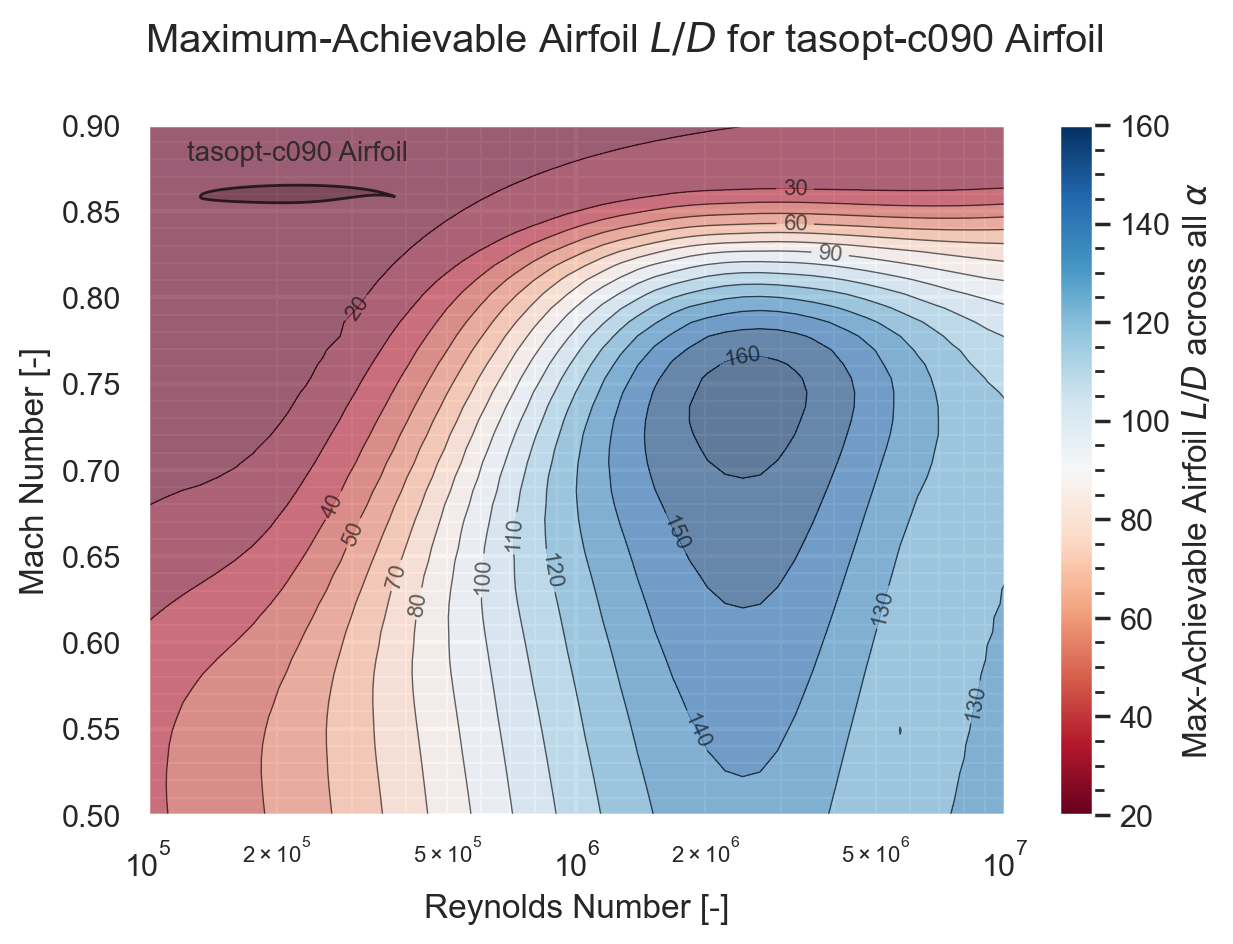

In [26]:
af = asb.Airfoil("tasopt-c090")

re = np.geomspace(1e5, 1e7, 50)
mach = np.linspace(0.5, 0.9, 50)
alpha = np.linspace(-3, 7, 50)

Re, Mach, Alpha = np.meshgrid(re, mach, alpha)

aero_f = af.get_aero_from_neuralfoil(
    alpha=Alpha.flatten(),
    Re=Re.flatten(),
    mach=Mach.flatten(),
)
aero = {
    k: np.reshape(v, Re.shape) for k, v in aero_f.items()
}

cmap = plt.get_cmap("RdBu")

fig, ax = plt.subplots()


LD = np.max(aero["CL"] / aero["CD"], axis=-1)

p.contour(
    re, mach, LD,
    levels=np.arange(0, 400, 10),
    x_log_scale=True,
    cmap=cmap, alpha=0.6,
    colorbar_label="Max-Achievable Airfoil $L/D$ across all $\\alpha$",
)
plt.clim(20, 160)
plt.xscale('log')

afax = ax.inset_axes([0.05, 0.8, 0.25, 0.20])
afax.fill(
    af.x(), af.y(),
    facecolor=(0, 0, 0, 0.2), linewidth=1, edgecolor=(0, 0, 0, 0.7)
)
afax.annotate(
    text=f"{af.name} Airfoil\n",
    xy=(0.5, 0),
    ha="center", va="bottom", fontsize=10,
    alpha=0.9
)
afax.axis('off')
afax.axis('equal')

p.show_plot(
    title=f"Maximum-Achievable Airfoil $L/D$ for {af.name} Airfoil",
    xlabel="Reynolds Number [-]",
    ylabel="Mach Number [-]",
)